# forecasting selling price of chicken with Bins

In [62]:
# libraries
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

!pip install category_encoders
import category_encoders as ce
from category_encoders import TargetEncoder


In [63]:
# reading file
df = pd.read_csv('/workspaces/forecasting/data/data.csv')
df.head()

,DAY_DATE,UNIT,TAILS,KG,SALES PER KG,TOTAL SALES,ABW,CHICKEN SIZE,PROVINCE
0,2017-01-01,LOMBOK,6237,11356.50,22000.00,249843000,1.82,MEDIUM,NUSA TENGGARA BARAT
1,2017-01-01,GARUT,2625,5446.80,17000.00,92595600,2.07,LARGE,JAWA BARAT
2,2017-01-01,SUMEDANG,7788,14176.80,16106.05,228332300,1.82,MEDIUM,JAWA BARAT
3,2017-01-01,CIREBON,7504,15958.00,17000.00,271286000,2.13,LARGE,JAWA BARAT
4,2017-01-01,PEKALONGAN,9121,16250.00,16500.00,268125000,1.78,MEDIUM,JAWA TENGAH


# cleaning

In [64]:
# changing the value name such that it matches the values in the supply and demand dataset
# finding for any nan values
df.isna().sum()
# pring out the rows with nan values
df[df.isna().any(axis=1)]

# change value name of the province column
df['PROVINCE'] = df['PROVINCE'].replace('DIY YOGYAKARTA', 'DI YOGYAKARTA')
# print out the unique values of the province column
df['PROVINCE'].unique()

array(['NUSA TENGGARA BARAT', 'JAWA BARAT', 'JAWA TENGAH', 'JAWA TIMUR',
       'SUMATERA UTARA', 'SUMATERA BARAT', 'JAMBI', 'BENGKULU',
       'SULAWESI SELATAN', 'KALIMANTAN SELATAN', 'DI YOGYAKARTA',
       'KALIMANTAN TIMUR', 'LAMPUNG', 'RIAU', 'BANTEN', 'BALI',
       'SULAWESI UTARA', 'SUMATERA SELATAN', 'SULAWESI BARAT',
       'SULAWESI TENGAH', 'KALIMANTAN BARAT', 'SULAWESI TENGGARA',
       'GORONTALO', 'ACEH', 'KALIMANTAN TENGAH'], dtype=object)

In [65]:
# removing outlier
df = df[df['SALES PER KG'] <= 35000]

# removing 'total sales' column
df = df.drop('TOTAL SALES', axis = 1)

# creating bins for prediction

# using sturges to print out the number of bins
sturges = int(np.ceil(1 + np.log2(len(df['SALES PER KG']))))
print(sturges)

max_value = 35000
bin_width = int((max_value - 0) // sturges)

# Correctly calculate 'bin_edges'
# Ensure 'bin_width' is added to 'max_value' to include the upper edge
bin_edges = np.arange(0, max_value + bin_width, bin_width)

# Use pd.cut to bin the data
df['price_bin'] = pd.cut(df['SALES PER KG'], bins=bin_edges, labels=False, right=False)

# Add 1 to change bins from 0-19 to 1-20
df['price_bin'] += 1

# Display the first few rows to verify
print(df.head())

# dropping sales per kg column as we already have price_bin
df = df.drop('SALES PER KG', axis = 1)

# dropping ABW 
df = df.drop('ABW', axis = 1)


20
     DAY_DATE        UNIT  TAILS       KG  SALES PER KG  ABW CHICKEN SIZE  \
0  2017-01-01      LOMBOK   6237 11356.50      22000.00 1.82       MEDIUM   
1  2017-01-01       GARUT   2625  5446.80      17000.00 2.07        LARGE   
2  2017-01-01    SUMEDANG   7788 14176.80      16106.05 1.82       MEDIUM   
3  2017-01-01     CIREBON   7504 15958.00      17000.00 2.13        LARGE   
4  2017-01-01  PEKALONGAN   9121 16250.00      16500.00 1.78       MEDIUM   

              PROVINCE  price_bin  
0  NUSA TENGGARA BARAT         13  
1           JAWA BARAT         10  
2           JAWA BARAT         10  
3           JAWA BARAT         10  
4          JAWA TENGAH         10  


## pre processing
- extracting date column
- splitting, scaling
- creating function to evaluate the model [call `results(y_test, predictions)`]


In [66]:
# extracting year and month from date column for seasonality trends
df['DAY_DATE'] = pd.to_datetime(df['DAY_DATE'], errors='coerce').dt.normalize()
df['YEAR'] = df['DAY_DATE'].dt.year
df['MONTH'] = df['DAY_DATE'].dt.month
df['DAY'] = df['DAY_DATE'].dt.day
df = df.drop('DAY_DATE', axis = 1)


In [67]:
df

,UNIT,TAILS,KG,CHICKEN SIZE,PROVINCE,price_bin,YEAR,MONTH,DAY
0,LOMBOK,6237,11356.50,MEDIUM,NUSA TENGGARA BARAT,13,2017,1,1
1,GARUT,2625,5446.80,LARGE,JAWA BARAT,10,2017,1,1
2,SUMEDANG,7788,14176.80,MEDIUM,JAWA BARAT,10,2017,1,1
3,CIREBON,7504,15958.00,LARGE,JAWA BARAT,10,2017,1,1
4,PEKALONGAN,9121,16250.00,MEDIUM,JAWA TENGAH,10,2017,1,1
...,...,...,...,...,...,...,...,...,...
382897,SRAGEN,510,618.40,SMALL,JAWA TENGAH,10,2024,1,27
382898,SLEMAN,48,63.20,SMALL,DI YOGYAKARTA,7,2024,1,28
382899,SRAGEN,315,415.60,SMALL,JAWA TENGAH,10,2024,1,28
382900,BOYOLALI,785,974.80,SMALL,JAWA TENGAH,10,2024,1,28


## demand and supply
importing the demand and supply dataset

In [68]:
# filtering for rows for year 2019 to 2023
df = df[(df['YEAR'] >= 2019) & (df['YEAR'] <= 2023)]

# removine rows that are earlier than december 2019
df = df[(df['YEAR'] >= 2019) & (df['MONTH'] >= 12)]


In [69]:
df

,UNIT,TAILS,KG,CHICKEN SIZE,PROVINCE,price_bin,YEAR,MONTH,DAY
165114,PAYAKUMBUH,1267,2856.00,LARGE,SUMATERA BARAT,11,2019,12,1
165115,SINJAI,3310,7799.50,LARGE,SULAWESI SELATAN,13,2019,12,1
165116,BANDAR JAYA,8236,22197.00,LARGE,LAMPUNG,10,2019,12,1
165117,BANDAR LAMPUNG,2565,4971.00,MEDIUM,LAMPUNG,11,2019,12,1
165118,BANYUASIN,696,1464.40,LARGE,SUMATERA SELATAN,10,2019,12,1
...,...,...,...,...,...,...,...,...,...
382498,BOYOLALI,430,901.40,BIG,JAWA TENGAH,10,2023,12,31
382499,BOYOLALI,294,605.00,BIG,JAWA TENGAH,10,2023,12,31
382500,BOYOLALI,432,962.40,BIG,JAWA TENGAH,10,2023,12,31
382501,GUNUNGKIDUL,200,370.80,MEDIUM,DI YOGYAKARTA,10,2023,12,31


In [70]:
# importing demand and supply dataset
df_demand_supply = pd.read_csv('/workspaces/forecasting/data/provinceDD&SS.csv')
df_demand_supply

# splitting the month_year column into separate month and year columns
df_demand_supply[['MONTH', 'YEAR']] = df_demand_supply['Month_Year'].str.split(' ', expand = True)

# mapping month to numerical values
month_num = {
    'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 
    'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12
}

# replacing month with numerical values
df_demand_supply['MONTH'] = df_demand_supply['MONTH'].replace(month_num)
df_demand_supply['YEAR'] = df_demand_supply['YEAR'].astype(int)

# dropping original month_year column
df_demand_supply.drop('Month_Year', axis = 1, inplace = True)
df_demand_supply

,PROVINCE,SupplyProvince,DemandProvince,MONTH,YEAR
0,ACEH,2687246,3930723,12,2019
1,BALI,5120529,5141045,12,2019
2,BANTEN,16349469,13433846,12,2019
3,BENGKULU,554903,1339242,12,2019
4,DI YOGYAKARTA,4206148,6313628,12,2019
...,...,...,...,...,...
1723,SULAWESI TENGGARA,104238,705272,12,2023
1724,SULAWESI UTARA,396941,1307670,12,2023
1725,SUMATERA BARAT,3689089,4922821,12,2023
1726,SUMATERA SELATAN,5467836,5767260,12,2023


In [71]:
# merging the demand and supply dataset with the main dataset
df = pd.merge(df, df_demand_supply, how = 'inner', on = ['YEAR', 'MONTH', 'PROVINCE'])
df

,UNIT,TAILS,KG,CHICKEN SIZE,PROVINCE,price_bin,YEAR,MONTH,DAY,SupplyProvince,DemandProvince
0,PAYAKUMBUH,1267,2856.00,LARGE,SUMATERA BARAT,11,2019,12,1,3885216,5993194
1,SINJAI,3310,7799.50,LARGE,SULAWESI SELATAN,13,2019,12,1,5447863,5931514
2,BANDAR JAYA,8236,22197.00,LARGE,LAMPUNG,10,2019,12,1,5404511,5618463
3,BANDAR LAMPUNG,2565,4971.00,MEDIUM,LAMPUNG,11,2019,12,1,5404511,5618463
4,BANYUASIN,696,1464.40,LARGE,SUMATERA SELATAN,10,2019,12,1,5758528,7021239
...,...,...,...,...,...,...,...,...,...,...,...
15050,BOYOLALI,430,901.40,BIG,JAWA TENGAH,10,2023,12,31,54958385,26285612
15051,BOYOLALI,294,605.00,BIG,JAWA TENGAH,10,2023,12,31,54958385,26285612
15052,BOYOLALI,432,962.40,BIG,JAWA TENGAH,10,2023,12,31,54958385,26285612
15053,GUNUNGKIDUL,200,370.80,MEDIUM,DI YOGYAKARTA,10,2023,12,31,3993820,5186026


In [72]:
# train test split before label encoding to prevent data leakage


X = df.drop('price_bin', axis=1)
y = df['price_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# checking for any nan values after splitting
print(X_train.isna().sum())
print(X_test.isna().sum())
print(y_train.isna().sum())
print(y_test.isna().sum())




UNIT              0
TAILS             0
KG                0
CHICKEN SIZE      0
PROVINCE          0
YEAR              0
MONTH             0
DAY               0
SupplyProvince    0
DemandProvince    0
dtype: int64
UNIT              0
TAILS             0
KG                0
CHICKEN SIZE      0
PROVINCE          0
YEAR              0
MONTH             0
DAY               0
SupplyProvince    0
DemandProvince    0
dtype: int64
0
0


In [73]:
# printing out the nan rows in the x_train dataset
X_train[X_train.isna().any(axis=1)] 


,UNIT,TAILS,KG,CHICKEN SIZE,PROVINCE,YEAR,MONTH,DAY,SupplyProvince,DemandProvince


In [74]:
# scaling numerical variable

scaler = StandardScaler()
columns_to_scale = ['KG', 'TAILS']
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [75]:
# creating function to evaluate the model
def results(y_test, predictions):
  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, predictions)

  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Mean Squared Error (MSE): {mse}")
  print(f"Root Mean Squared Error (RMSE): {rmse}")
  print(f"R-squared (R²): {r2}")


# encoding

In [76]:
# encoding of columns
# label encoding for province

label_encoder = LabelEncoder()
X_train['SIZE ENCODE'] = label_encoder.fit_transform(X_train['CHICKEN SIZE'])
X_test['SIZE ENCODE'] = label_encoder.transform(X_test['CHICKEN SIZE'])

# dropping chicken size column
X_train = X_train.drop(['CHICKEN SIZE'], axis = 1)
X_test = X_test.drop(['CHICKEN SIZE'], axis = 1)


# one hot encoding for province

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[['PROVINCE']])
X_train_encoded = encoder.transform(X_train[['PROVINCE']])
X_test_encoded = encoder.transform(X_test[['PROVINCE']])

# Convert the encoded matrices back to dataframes for easier manipulation
columns = encoder.get_feature_names_out(['PROVINCE'])
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=columns, index=X_test.index)

# merge back the dataframe
X_train = pd.concat([X_train.drop('PROVINCE', axis=1), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop('PROVINCE', axis=1), X_test_encoded_df], axis=1)


# one hot encoding for unit
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[['UNIT']])
X_train_encoded_unit = encoder.transform(X_train[['UNIT']])
X_test_encoded_unit = encoder.transform(X_test[['UNIT']])

# Convert the encoded matrices back to dataframes for easier manipulation
columns = encoder.get_feature_names_out(['UNIT'])
X_train_encoded_df_unit = pd.DataFrame(X_train_encoded_unit.toarray(), columns=columns, index=X_train.index)
X_test_encoded_df_unit = pd.DataFrame(X_test_encoded_unit.toarray(), columns=columns, index=X_test.index)

# merge back the dataframe, dropping unit column
X_train = pd.concat([X_train.drop('UNIT', axis=1), X_train_encoded_df_unit], axis=1)
X_test = pd.concat([X_test.drop('UNIT', axis=1), X_test_encoded_df_unit], axis=1)




In [77]:
X_train

,TAILS,KG,YEAR,MONTH,DAY,SupplyProvince,DemandProvince,SIZE ENCODE,PROVINCE_ACEH,PROVINCE_BALI,...,UNIT_TANJUNG BINTANG,UNIT_TASIKMALAYA,UNIT_TEBING TINGGI,UNIT_TEGAL,UNIT_TULANG BAWANG,UNIT_TULUNGAGUNG,UNIT_UNGARAN,UNIT_WABIN,UNIT_WONOGIRI,UNIT_YOGYAKARTA
12179,-0.87,-0.90,2021,12,17,2300037,4222539,3,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
14448,-0.28,-0.32,2021,12,31,2985299,4704630,2,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13769,-0.94,-0.88,2021,12,27,28211360,34531309,1,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12070,0.49,0.67,2021,12,16,426373,1051299,1,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
11502,-0.47,-0.30,2021,12,13,1467591,2763960,1,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,-0.11,-0.13,2020,12,1,4759588,4868827,2,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13418,0.03,-0.05,2021,12,24,2985299,4704630,2,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5390,0.01,0.02,2020,12,2,60416057,49183167,2,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
860,1.92,1.18,2019,12,5,64997688,51933021,3,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# trying lazy predict

In [78]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [79]:
# libraries
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin


In [80]:
print(lazypredict.Supervised.REGRESSORS)

[('AdaBoostRegressor', <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>), ('BaggingRegressor', <class 'sklearn.ensemble._bagging.BaggingRegressor'>), ('BayesianRidge', <class 'sklearn.linear_model._bayes.BayesianRidge'>), ('DecisionTreeRegressor', <class 'sklearn.tree._classes.DecisionTreeRegressor'>), ('DummyRegressor', <class 'sklearn.dummy.DummyRegressor'>), ('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>), ('ElasticNetCV', <class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>), ('ExtraTreeRegressor', <class 'sklearn.tree._classes.ExtraTreeRegressor'>), ('ExtraTreesRegressor', <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>), ('GammaRegressor', <class 'sklearn.linear_model._glm.glm.GammaRegressor'>), ('GaussianProcessRegressor', <class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'>), ('GradientBoostingRegressor', <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>), ('HistGradientBoostingRegressor', <class 's

In [81]:
'''
    chosen_regressors = [
    'SVR', 
    'BaggingRegressor',
    'ExtraTreesRegressor',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'LGBMRegressor',
    'XGBRegressor',
    'CatBoostRegressor',
    'HistGradientBoostingRegressor',
    'AdaBoostRegressor',
    'KNeighborsRegressor',
    'DecisionTreeRegressor'
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and est[0] in chosen_regressors)

]'''

# initialising the regressor with chosen regressors
reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)


In [82]:

# fitting and evaluate models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/42 [00:00<?, ?it/s]

  2%|▏         | 1/42 [00:01<00:52,  1.29s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.38822110122196596, 'Adjusted R-Squared': 0.3545550349380012, 'RMSE': 1.0140434750373453, 'Time taken': 1.2924137115478516}


  7%|▋         | 3/42 [00:02<00:23,  1.67it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.8060589504376698, 'Adjusted R-Squared': 0.7953864145872367, 'RMSE': 0.570944901345103, 'Time taken': 0.7051398754119873}
{'Model': 'BayesianRidge', 'R-Squared': 0.5196540383942234, 'Adjusted R-Squared': 0.493220699462535, 'RMSE': 0.8985378997525741, 'Time taken': 0.1851484775543213}


 10%|▉         | 4/42 [00:02<00:16,  2.30it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.6862230146049186, 'Adjusted R-Squared': 0.6689559319876639, 'RMSE': 0.7262227860912884, 'Time taken': 0.1832883358001709}
{'Model': 'DummyRegressor', 'R-Squared': -0.00021885869723559104, 'Adjusted R-Squared': -0.05526069564622471, 'RMSE': 1.2966024788204467, 'Time taken': 0.03820300102233887}
{'Model': 'ElasticNet', 'R-Squared': 0.015067937186860836, 'Adjusted R-Squared': -0.039132670545933834, 'RMSE': 1.2866560483416285, 'Time taken': 0.04514026641845703}


 19%|█▉        | 8/42 [00:05<00:21,  1.61it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.5205660437014976, 'Adjusted R-Squared': 0.49418289223326595, 'RMSE': 0.8976844933128549, 'Time taken': 2.781524419784546}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.69274356908731, 'Adjusted R-Squared': 0.6758353112347715, 'RMSE': 0.7186374058055397, 'Time taken': 0.14821720123291016}


 24%|██▍       | 10/42 [00:09<00:37,  1.16s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8252041875644915, 'Adjusted R-Squared': 0.815585210153915, 'RMSE': 0.5420318919611855, 'Time taken': 4.272757053375244}
{'Model': 'GammaRegressor', 'R-Squared': 0.40231882532803775, 'Adjusted R-Squared': 0.36942855388622275, 'RMSE': 1.0022916600492124, 'Time taken': 0.11937570571899414}


 26%|██▌       | 11/42 [00:47<05:39, 10.96s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -32.8261753173401, 'Adjusted R-Squared': -34.687622749805016, 'RMSE': 7.540250531022452, 'Time taken': 37.230304479599}


 29%|██▊       | 12/42 [00:49<04:17,  8.58s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.6386300094212155, 'Adjusted R-Squared': 0.6187438935709284, 'RMSE': 0.7793550796529983, 'Time taken': 2.4228901863098145}


 31%|███       | 13/42 [00:50<03:06,  6.43s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7674408029020242, 'Adjusted R-Squared': 0.7546431183789319, 'RMSE': 0.6252102477414963, 'Time taken': 1.0709302425384521}


 33%|███▎      | 14/42 [00:50<02:10,  4.66s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.5186660157226404, 'Adjusted R-Squared': 0.49217830610765767, 'RMSE': 0.899461525472337, 'Time taken': 0.32716822624206543}


 36%|███▌      | 15/42 [00:51<01:31,  3.38s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7053578781223365, 'Adjusted R-Squared': 0.6891437830873581, 'RMSE': 0.7037311010869121, 'Time taken': 0.2735013961791992}


 40%|████      | 17/42 [01:00<01:30,  3.63s/it]

{'Model': 'KernelRidge', 'R-Squared': -78.08270976010431, 'Adjusted R-Squared': -82.43461492390956, 'RMSE': 11.529224584844522, 'Time taken': 9.249894618988037}
{'Model': 'Lars', 'R-Squared': -2.369247437640878e+28, 'Adjusted R-Squared': -2.4996266341742176e+28, 'RMSE': 199555884135842.0, 'Time taken': 0.10041308403015137}


 43%|████▎     | 18/42 [01:00<01:04,  2.68s/it]

{'Model': 'LarsCV', 'R-Squared': 0.42862551881537536, 'Adjusted R-Squared': 0.3971828992759481, 'RMSE': 0.9799857218103069, 'Time taken': 0.4555478096008301}
{'Model': 'Lasso', 'R-Squared': -0.00021885869723559104, 'Adjusted R-Squared': -0.05526069564622471, 'RMSE': 1.2966024788204467, 'Time taken': 0.07434630393981934}


 48%|████▊     | 20/42 [01:03<00:45,  2.07s/it]

{'Model': 'LassoCV', 'R-Squared': 0.5211939093433848, 'Adjusted R-Squared': 0.49484530919158365, 'RMSE': 0.8970964979333852, 'Time taken': 2.641167640686035}
{'Model': 'LassoLars', 'R-Squared': -0.00021885869723559104, 'Adjusted R-Squared': -0.05526069564622471, 'RMSE': 1.2966024788204467, 'Time taken': 0.0656743049621582}


 55%|█████▍    | 23/42 [01:04<00:20,  1.06s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.4922202242130769, 'Adjusted R-Squared': 0.46427720816030893, 'RMSE': 0.9238405652609801, 'Time taken': 0.20258307456970215}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5093491323167407, 'Adjusted R-Squared': 0.4823487165346616, 'RMSE': 0.908124962654713, 'Time taken': 0.1805894374847412}


 57%|█████▋    | 24/42 [01:04<00:15,  1.20it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.5200640124857963, 'Adjusted R-Squared': 0.49365323434358455, 'RMSE': 0.8981543679604107, 'Time taken': 0.1236884593963623}


 60%|█████▉    | 25/42 [01:07<00:25,  1.53s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.5098306641213479, 'Adjusted R-Squared': 0.48285674693489566, 'RMSE': 0.9076792298286904, 'Time taken': 3.5274364948272705}


 62%|██████▏   | 26/42 [01:21<01:17,  4.85s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.710783396285414, 'Adjusted R-Squared': 0.6948678663929534, 'RMSE': 0.6972217701405597, 'Time taken': 13.978176832199097}


 69%|██████▉   | 29/42 [01:32<00:47,  3.68s/it]

{'Model': 'NuSVR', 'R-Squared': 0.5707731281448487, 'Adjusted R-Squared': 0.5471528621507167, 'RMSE': 0.8493814652417179, 'Time taken': 10.828632354736328}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.4510982683469339, 'Adjusted R-Squared': 0.4208923195668668, 'RMSE': 0.9605204786633305, 'Time taken': 0.04797720909118652}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.4510982683469339, 'Adjusted R-Squared': 0.4208923195668668, 'RMSE': 0.9605204786633305, 'Time taken': 0.13541865348815918}


 74%|███████▍  | 31/42 [01:33<00:23,  2.14s/it]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.03674208789343336, 'Adjusted R-Squared': -0.016265795808189765, 'RMSE': 1.2724203922867001, 'Time taken': 0.11642241477966309}
{'Model': 'PoissonRegressor', 'R-Squared': 0.48653724716107305, 'Adjusted R-Squared': 0.4582814980563722, 'RMSE': 0.9289959071001787, 'Time taken': 0.16097307205200195}


 76%|███████▌  | 32/42 [01:37<00:28,  2.86s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.12370888913213363, 'Adjusted R-Squared': -0.1855463569182343, 'RMSE': 1.3743148409175112, 'Time taken': 4.825397729873657}


 79%|███████▊  | 33/42 [01:38<00:21,  2.38s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -2.825203634044591e+26, 'Adjusted R-Squared': -2.9806740057743497e+26, 'RMSE': 21791353519779.926, 'Time taken': 1.1220436096191406}


 81%|████████  | 34/42 [01:45<00:27,  3.48s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8228092076623652, 'Adjusted R-Squared': 0.8130584350030562, 'RMSE': 0.545732607033221, 'Time taken': 6.25631856918335}
{'Model': 'Ridge', 'R-Squared': 0.5216294377663593, 'Adjusted R-Squared': 0.49530480465360727, 'RMSE': 0.8966883996238066, 'Time taken': 0.06325888633728027}


 86%|████████▌ | 36/42 [01:45<00:11,  1.99s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.5216924325965349, 'Adjusted R-Squared': 0.49537126607626003, 'RMSE': 0.8966293569091536, 'Time taken': 0.21653246879577637}


 88%|████████▊ | 37/42 [01:45<00:07,  1.56s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.4947828805772676, 'Adjusted R-Squared': 0.4669808869742641, 'RMSE': 0.9215064032603248, 'Time taken': 0.20815372467041016}


 93%|█████████▎| 39/42 [01:58<00:09,  3.22s/it]

{'Model': 'SVR', 'R-Squared': 0.5778900663253247, 'Adjusted R-Squared': 0.5546614439674824, 'RMSE': 0.8423103060754246, 'Time taken': 12.464138269424438}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5200640124857963, 'Adjusted R-Squared': 0.49365323434358455, 'RMSE': 0.8981543679604107, 'Time taken': 0.12768173217773438}


 95%|█████████▌| 40/42 [01:58<00:04,  2.36s/it]

{'Model': 'TweedieRegressor', 'R-Squared': 0.4030448247517039, 'Adjusted R-Squared': 0.37019450490803674, 'RMSE': 1.0016827365088528, 'Time taken': 0.11376190185546875}


 98%|█████████▊| 41/42 [01:58<00:01,  1.80s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.7881130380918598, 'Adjusted R-Squared': 0.776452942396249, 'RMSE': 0.5967761318970698, 'Time taken': 0.37598299980163574}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 12044, number of used features: 153
[LightGBM] [Info] Start training from score 11.475174


100%|██████████| 42/42 [01:59<00:00,  2.83s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.7697210492224728, 'Adjusted R-Squared': 0.7570488461828402, 'RMSE': 0.6221375995476037, 'Time taken': 0.21047663688659668}


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.82,0.83,0.54,4.27
RandomForestRegressor,0.81,0.82,0.55,6.26
BaggingRegressor,0.80,0.81,0.57,0.71
XGBRegressor,0.78,0.79,0.60,0.38
LGBMRegressor,0.76,0.77,0.62,0.21
HistGradientBoostingRegressor,0.75,0.77,0.63,1.07
MLPRegressor,0.69,0.71,0.70,13.98
KNeighborsRegressor,0.69,0.71,0.70,0.27
ExtraTreeRegressor,0.68,0.69,0.72,0.15


In [83]:
# filtering out the top 5 models
top_5_models = models.head(5)
top_5_models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.82,0.83,0.54,4.27
RandomForestRegressor,0.81,0.82,0.55,6.26
BaggingRegressor,0.80,0.81,0.57,0.71
XGBRegressor,0.78,0.79,0.60,0.38
LGBMRegressor,0.76,0.77,0.62,0.21


In [84]:
# trying CatBoostRegressor
from catboost import CatBoostRegressor

cb = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=100)
# fitting the model
cb.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=100)

# making predictions
predictions = cb.predict(X_test)

# results 
results(y_test, predictions)
results

0:	learn: 1.2274047	test: 1.2418868	best: 1.2418868 (0)	total: 1.97ms	remaining: 1.96s
100:	learn: 0.6609947	test: 0.6988349	best: 0.6988349 (100)	total: 176ms	remaining: 1.57s
200:	learn: 0.5868129	test: 0.6455161	best: 0.6455161 (200)	total: 327ms	remaining: 1.3s
300:	learn: 0.5465392	test: 0.6210595	best: 0.6210595 (300)	total: 475ms	remaining: 1.1s
400:	learn: 0.5168968	test: 0.6041516	best: 0.6041516 (400)	total: 623ms	remaining: 931ms
500:	learn: 0.4950327	test: 0.5956385	best: 0.5955858 (499)	total: 772ms	remaining: 769ms
600:	learn: 0.4768649	test: 0.5885465	best: 0.5885465 (600)	total: 932ms	remaining: 619ms
700:	learn: 0.4603652	test: 0.5831260	best: 0.5830765 (696)	total: 1.13s	remaining: 482ms
800:	learn: 0.4465353	test: 0.5789080	best: 0.5789080 (800)	total: 1.28s	remaining: 318ms
900:	learn: 0.4338069	test: 0.5757830	best: 0.5757830 (900)	total: 1.43s	remaining: 157ms
999:	learn: 0.4218770	test: 0.5732579	best: 0.5731948 (980)	total: 1.58s	remaining: 0us

bestTest = 0.573

<function __main__.results(y_test, predictions)>

# Neural Network
using entity embeddings to train the neural network


## setting up the model
creating entity embeddings <br>
`cat_col1` = `PROVINCE` <br>
`cat_col2` = `CHICKEN SIZE` <br>
`cat_col3` = `SIZE` <br>

In [93]:
# original dataset `df`

# importing libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Concatenate, Dense, Flatten

# getting the unique values of the categorical columns
cat_columns = ['PROVINCE', 'CHICKEN SIZE', 'UNIT']
unique_cat1 = df['PROVINCE'].nunique()
unique_cat2 = df['CHICKEN SIZE'].nunique()
unique_cat3 = df['UNIT'].nunique()

# getting numerical columns
num_columns = df.columns.difference(cat_columns)
numerical_data = df[num_columns]

# scaling the numerical features
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# defining the input layer
num_input = Input(shape=(numerical_data_scaled.shape[1],), name='num_input')

# embedding the categorical columns
cat_input1 = Input(shape = (1,), name='cat_input1')
cat_embed1 = Embedding(input_dim=unique_cat1, output_dim = int(min(np.ceil(unique_cat1 /2), 50)))(cat_input1)
cat_embed1 = Flatten()(cat_embed1)

cat_input2 = Input(shape = (1,), name='cat_input2')
cat_embed2 = Embedding(input_dim=unique_cat2, output_dim = int(min(np.ceil(unique_cat2 /2), 50)))(cat_input2)
cat_embed2 = Flatten()(cat_embed2)


cat_input3 = Input(shape = (1,), name='cat_input3')
cat_embed3 = Embedding(input_dim=unique_cat3, output_dim = int(min(np.ceil(unique_cat3 /2), 50)))(cat_input3)
cat_embed3 = Flatten()(cat_embed3)


# concatenate the embeddings with numerical input
concatenated = Concatenate()([cat_embed1, cat_embed2, cat_embed3, num_input])


# adding the dense layer ontop of the embeddings
dense_output = Dense(128, activation = 'relu')(concatenated)
dense_output = Dense(64, activation = 'relu')(dense_output)
output = Dense(1)(dense_output)

# creating the model
model = Model(inputs = [cat_input1, cat_input2, cat_input3, num_input], outputs = output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  


 cat_input1 (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 cat_input2 (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 cat_input3 (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 1, 13)                325       ['cat_input1[0][0]']          
                                                                                                  
 embedding_11 (Embedding)    (None, 1, 2)                 8         ['cat_input2[0][0]']          
                                                                                                  
 embedding

## training the model


In [ ]:
# train model
X_train_cat1 = X_train['PROVINCE']
X_train_cat2 = X_train['CHICKEN SIZE']
X_train_cat3 = X_train['UNIT']
X_train_num = X_train.drop(['PROVINCE', 'CHICKEN SIZE', 'UNIT'], axis = 1)

# fitting the model


In [91]:
df

,UNIT,TAILS,KG,CHICKEN SIZE,PROVINCE,price_bin,YEAR,MONTH,DAY,SupplyProvince,DemandProvince
0,PAYAKUMBUH,1267,2856.00,LARGE,SUMATERA BARAT,11,2019,12,1,3885216,5993194
1,SINJAI,3310,7799.50,LARGE,SULAWESI SELATAN,13,2019,12,1,5447863,5931514
2,BANDAR JAYA,8236,22197.00,LARGE,LAMPUNG,10,2019,12,1,5404511,5618463
3,BANDAR LAMPUNG,2565,4971.00,MEDIUM,LAMPUNG,11,2019,12,1,5404511,5618463
4,BANYUASIN,696,1464.40,LARGE,SUMATERA SELATAN,10,2019,12,1,5758528,7021239
...,...,...,...,...,...,...,...,...,...,...,...
15050,BOYOLALI,430,901.40,BIG,JAWA TENGAH,10,2023,12,31,54958385,26285612
15051,BOYOLALI,294,605.00,BIG,JAWA TENGAH,10,2023,12,31,54958385,26285612
15052,BOYOLALI,432,962.40,BIG,JAWA TENGAH,10,2023,12,31,54958385,26285612
15053,GUNUNGKIDUL,200,370.80,MEDIUM,DI YOGYAKARTA,10,2023,12,31,3993820,5186026


Epoch 1/100
339/339 [==============================] - 1s 1ms/step - loss: 321104838656.0000 - mae: 123220.4141 - val_loss: 52483396.0000 - val_mae: 5524.1006
Epoch 2/100
339/339 [==============================] - 0s 1ms/step - loss: 41420740.0000 - mae: 4618.7798 - val_loss: 28234032.0000 - val_mae: 3835.6472
Epoch 3/100
339/339 [==============================] - 0s 1ms/step - loss: 20185572.0000 - mae: 3167.2327 - val_loss: 9446453.0000 - val_mae: 2045.1842
Epoch 4/100
339/339 [==============================] - 0s 1ms/step - loss: 6588207.0000 - mae: 1593.1550 - val_loss: 4124622.2500 - val_mae: 1210.5474
Epoch 5/100
339/339 [==============================] - 0s 1ms/step - loss: 3645962.2500 - mae: 1008.6276 - val_loss: 2593703.5000 - val_mae: 858.6125
Epoch 6/100
339/339 [==============================] - 0s 1ms/step - loss: 2381865.0000 - mae: 764.1129 - val_loss: 1900219.3750 - val_mae: 769.4922
Epoch 7/100
339/339 [==============================] - 0s 1ms/step - loss: 1663770.125

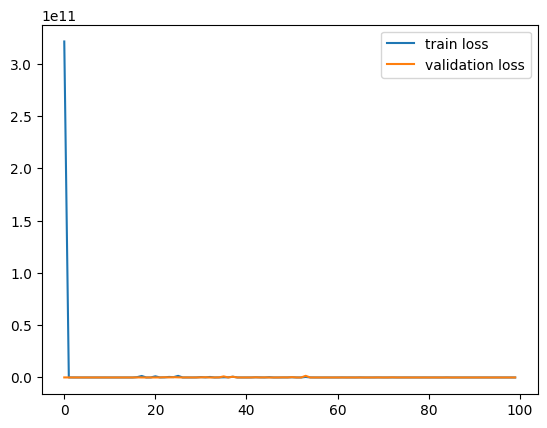

In [85]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np


# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Single output node for regression
])

# Compile the model, specifying the optimizer, loss function, and metric
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model on the training data
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1)

# Predict the target on the testing set
predictions = model.predict(X_test).flatten()

# Evaluate the model performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# You can plot the training history to check how the loss and metric evolved over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
